In [ ]:
# --- Imports ---
import math, time, json, os
import requests
import pandas as pd

# --- Paramètres à adapter ---
MAX_ROWS = 50_000         # nombre max de lignes à récupérer
TARGETS  = []             # on prend une liste vide pour avoir toutes les cibles
MIN_PER_TARGET = 0        # ex: 200 pour garder seulement les cibles avec >=200 exemples
DEDUPE   = "median"       # fusionne les doublons par médiane de pIC50
OUT_CSV  = "chembl_ic50_pic50.csv"  # nom du CSV de sortie

# Pause entre pages pour ménager l'API
SLEEP_S  = 0.2

API = "https://www.ebi.ac.uk/chembl/api/data/activity.json"
PAGE_SIZE = 1000  # max ChEMBL par page

# conversion des unités d'IC50 vers molaires. En effet, IC50 est souvent donné en M, mM, µM.
UNIT_TO_M = {
    "M": 1.0,
    "MM": 1e-3,
    "UM": 1e-6, "µM": 1e-6,
    "NM": 1e-9,
    "PM": 1e-12,
}

# IC50: concenration à laquelle un ligan inhibe 50% de la cible (en molaires)
# Le log est utilisé pour avoir des valeurs plus lisibles et comparables
def ic50_to_pIC50(value, unit):
    """Convertit (IC50, unité) en pIC50 = -log10(IC50 en molaires)."""
    if value is None:
        return None
    try:
        v = float(value)
    except:
        return None
    if v <= 0:
        return None
    u = (unit or "").strip().upper()
    if u not in UNIT_TO_M:
        return None
    ic50_molar = v * UNIT_TO_M[u]
    if ic50_molar <= 0:
        return None
    return -math.log10(ic50_molar)

from urllib.parse import urljoin

# créer une session pour réutiliser les connexions HTTP
def fetch_chembl_ic50(max_rows=50_000, targets=None, sleep_s=0.2):
    """
    Récupère des activities IC50 depuis l'API ChEMBL.
    targets: liste de noms de cibles (ex. "ABL1") ou IDs (ex. "CHEMBL1862"). Vide/None => toutes.
    """
    BASE = "https://www.ebi.ac.uk"
    API  = BASE + "/chembl/api/data/activity.json"
    rows, pulled = [], 0
    session = requests.Session()

    fields = ",".join([
        "molecule_chembl_id",
        "canonical_smiles",
        "target_chembl_id",
        "target_pref_name",
        "standard_value",
        "standard_units",
        "standard_type",
        "assay_chembl_id",
    ])

    # on limite les mesures à IC50
    params = {"standard_type": "IC50", "limit": PAGE_SIZE, "offset": 0, "only": fields}

    # rejette les lignes sans SMILES, valeur IC50 ou unités
    def accept_row(a):
        smi = a.get("canonical_smiles")
        val = a.get("standard_value")
        unt = a.get("standard_units")
        if not smi or val is None or not unt:
            return False
        if targets:
            wanted = {t.upper() for t in targets}
            tname = (a.get("target_pref_name") or "").upper()
            tid   = (a.get("target_chembl_id") or "").upper()
            if (tname not in wanted) and (tid not in wanted):
                return False
        return True

    # Boucle de pagination robuste
    url = API
    while url and pulled < max_rows:
        r = session.get(url, params=params if url == API else None, timeout=60)
        if r.status_code != 200:
            print(f"[warn] HTTP {r.status_code} on {url} -> stop")
            break
        data = r.json()
        acts = data.get("activities", [])
        for a in acts:
            if not accept_row(a):
                continue
            rows.append({
                "molecule_chembl_id": a.get("molecule_chembl_id"),
                "smiles": a.get("canonical_smiles"),
                "target_chembl_id": a.get("target_chembl_id"),
                "target": a.get("target_pref_name"),
                "IC50_value": a.get("standard_value"),
                "IC50_units": a.get("standard_units"),
                "assay_chembl_id": a.get("assay_chembl_id"),
            })
            pulled += 1
            if pulled >= max_rows:
                break

        if pulled >= max_rows:
            break

        next_url = data.get("page_meta", {}).get("next")
        if not next_url:
            break
        # ⚠️ Si 'next' est relatif, on le résout contre le host
        url = next_url if next_url.startswith("http") else urljoin(BASE, next_url)
        # Après la première page, on ne renvoie plus 'params' (le next contient déjà les query params)
        params = None
        time.sleep(sleep_s)

    return pd.DataFrame(rows)

    def process_activities(acts):
        nonlocal pulled, rows
        for a in acts:
            if not accept_row(a):
                continue
            rows.append({
                "molecule_chembl_id": a.get("molecule_chembl_id"),
                "smiles": a.get("canonical_smiles"),
                "target_chembl_id": a.get("target_chembl_id"),
                "target": a.get("target_pref_name"),
                "IC50_value": a.get("standard_value"),
                "IC50_units": a.get("standard_units"),
                "assay_chembl_id": a.get("assay_chembl_id"),
            })
            pulled += 1
            if pulled >= max_rows:
                break

    # Traite la page initiale
    acts = data.get("activities", [])
    process_activities(acts)

    # Paginer via "next"
    next_url = data.get("page_meta", {}).get("next")

    while next_url and pulled < max_rows:
        time.sleep(sleep_s)
        r = session.get(next_url, timeout=60)
        if r.status_code != 200:
            print(f"[warn] HTTP {r.status_code} sur next -> stop")
            break
        data = r.json()
        acts = data.get("activities", [])
        if not acts:
            break
        process_activities(acts)
        next_url = data.get("page_meta", {}).get("next")

    return pd.DataFrame(rows)

# convertit ic50 a pIC50, nettoie les doublons et filtre les cibles
def clean_to_pic50(df, dedupe="median", min_per_target=0):
    """Nettoyage, conversion pIC50, dédoublonnage et filtrage."""
    if df.empty:
        return df

    # Conversion pIC50
    df["pIC50"] = df.apply(lambda r: ic50_to_pIC50(r["IC50_value"], r["IC50_units"]), axis=1)
    df = df.dropna(subset=["pIC50", "smiles", "target"]).reset_index(drop=True)

    # Dédoublonnage (smiles,target)
    if dedupe in ("median", "mean"):
        agg = {"pIC50": "median" if dedupe == "median" else "mean"}
        df = df.groupby(["smiles", "target"], as_index=False).agg(agg)

    # Filtre cibles avec peu d'exemples
    if min_per_target and min_per_target > 0:
        counts = df["target"].value_counts()
        keep = counts[counts >= min_per_target].index
        df = df[df["target"].isin(keep)].reset_index(drop=True)

    # Colonnes finales minimales pour le modèle
    out = df[["smiles", "target", "pIC50"]].copy()
    return out

# 1) Fetch depuis l'API
print(f"[info] Fetch ChEMBL… MAX_ROWS={MAX_ROWS}, TARGETS={TARGETS or 'ALL'}")
raw_df = fetch_chembl_ic50(max_rows=MAX_ROWS, targets=TARGETS, sleep_s=SLEEP_S)
print(f"[info] lignes récupérées (brut) = {len(raw_df)}")
display(raw_df.head(3))

# 2) Nettoyage + conversion pIC50 + dédoublonnage + filtre
df = clean_to_pic50(raw_df, dedupe=DEDUPE, min_per_target=MIN_PER_TARGET)
print(f"[info] lignes après clean/dedupe/filtre = {len(df)}")
display(df.head(5))

# 3) Stat rapide
print("\n[stats] top cibles par nombre d'exemples :")
display(df["target"].value_counts().head(15))

# Sauvegarde pour ton modèle
df.to_csv(OUT_CSV, index=False)
print(f"[done] Écrit: {OUT_CSV}")

# Rappel d'intégration :
print("\n[tip] Ensuite, entraîne ton modèle avec :")
print(f"python mini_affinity.py --csv {OUT_CSV} --plot")



[info] Fetch ChEMBL… MAX_ROWS=50000, TARGETS=ALL
[info] lignes récupérées (brut) = 50000


,molecule_chembl_id,smiles,target_chembl_id,target,IC50_value,IC50_units,assay_chembl_id
0,CHEMBL113081,c1ccc(-c2nc3c(-c4nc5ccccc5o4)cccc3o2)cc1,CHEMBL1806,DNA topoisomerase II alpha,100000.0,nM,CHEMBL663853
1,CHEMBL324340,Cc1ccc2oc(-c3cccc(N4C(=O)c5ccc(C(=O)O)cc5C4=O)...,CHEMBL3921,Heparanase,2500.0,nM,CHEMBL872937
2,CHEMBL324340,Cc1ccc2oc(-c3cccc(N4C(=O)c5ccc(C(=O)O)cc5C4=O)...,CHEMBL3879801,NON-PROTEIN TARGET,50000.0,nM,CHEMBL693237


[info] lignes après clean/dedupe/filtre = 39474


,smiles,target,pIC50
0,Br.Br.CCCCCCCCCCNC(=O)C1CCCN(Cc2ccc(CN3CCCC(C(...,Homo sapiens,3.064392
1,Br.Br.CCCCN(C)C(=O)C1CCCN(Cc2ccc(CN3CCCC(C(=O)...,Homo sapiens,4.655608
2,Br.Br.CCCCN(CCCC)C(=O)C1CCCN(Cc2ccc(CN3CCCC(C(...,Homo sapiens,4.231362
3,Br.Br.CCCN(Cc1ccccc1)C(=O)C1CCCN(Cc2ccc(CN3CCC...,Homo sapiens,4.137272
4,Br.Br.CCN(CC)C(=O)C1CCCN(Cc2ccc(CN3CCCC(C(=O)N...,Homo sapiens,4.367320



[stats] top cibles par nombre d'exemples :


target
Unchecked                                       1177
Cyclooxygenase-2                                 667
L1210                                            663
Homo sapiens                                     639
Rattus norvegicus                                546
Human immunodeficiency virus type 1 protease     486
Endothelin receptor ET-A                         444
Arachidonate 5-lipoxygenase                      412
Cyclooxygenase-1                                 401
Cavia porcellus                                  401
Renin                                            383
Thrombin                                         382
GABA-A receptor; anion channel                   373
Epidermal growth factor receptor erbB1           371
Dopamine D2 receptor                             371
Name: count, dtype: int64

[done] Écrit: chembl_ic50_pic50.csv

[tip] Ensuite, entraîne ton modèle avec :
python mini_affinity.py --csv chembl_ic50_pic50.csv --plot


In [14]:
df.to_csv(r"C:\Users\Mohamed\Documents\Hackathon\dataset.csv", index=False)

In [30]:
df = pd.read_csv(r"C:\Users\Mohamed\Documents\Hackathon\dataset.csv")

In [31]:
def clean_dataset_for_high_r2(df, min_per_target=300, pmin=4.0, pmax=10.0,
                              dedupe="median", z_trim=3.0, use_rdkit=True):
    import numpy as np, pandas as pd
    df = df.copy()

    # 0) colonnes de base
    assert {"smiles","target","pIC50"}.issubset(df.columns)
    df = df.dropna(subset=["smiles","target","pIC50"])
    df["pIC50"] = pd.to_numeric(df["pIC50"], errors="coerce")
    df = df.dropna(subset=["pIC50"]).reset_index(drop=True)

    # 1) range raisonnable (coupe extrêmes)
    df = df[(df["pIC50"] >= pmin) & (df["pIC50"] <= pmax)].reset_index(drop=True)

    # 2) standardisation chimique (si RDKit dispo)
    if use_rdkit:
        try:
            from rdkit import Chem
            from rdkit.Chem.MolStandardize import rdMolStandardize
            def std_smiles(s):
                mol = Chem.MolFromSmiles(s)
                if mol is None: return None
                # enlever sels/contre-ions
                frag = rdMolStandardize.LargestFragmentChooser().choose(mol)
                # neutraliser (simple)
                uncharger = rdMolStandardize.Uncharger()
                frag = uncharger.uncharge(frag)
                # canonicaliser
                return Chem.MolToSmiles(frag, isomericSmiles=True, canonical=True)
            df["smiles_std"] = df["smiles"].map(std_smiles)
            df = df.dropna(subset=["smiles_std"]).reset_index(drop=True)
            use_col = "smiles_std"
        except Exception:
            use_col = "smiles"
    else:
        use_col = "smiles"

    # 3) dédoublonnage (même molécule/cible)
    if dedupe in ("median","mean"):
        agg = {"pIC50": "median" if dedupe=="median" else "mean"}
        df = df.groupby([use_col,"target"], as_index=False).agg(agg)
    else:
        df = df.rename(columns={use_col: "smiles"}).copy()

    # si pas de groupby ci-dessus, assure la colonne s'appelle 'smiles'
    if use_col in df.columns and use_col != "smiles":
        df = df.rename(columns={use_col: "smiles"})

    # 4) trim par cible (z-score)
    def ztrim(group):
        y = group["pIC50"].values
        mu, sd = np.mean(y), np.std(y) + 1e-8
        z = np.abs((y - mu) / sd)
        return group[z <= z_trim]
    df = df.groupby("target", group_keys=False).apply(ztrim).reset_index(drop=True)

    # 5) filtre cibles peu représentées
    counts = df["target"].value_counts()
    keep = counts[counts >= min_per_target].index
    df = df[df["target"].isin(keep)].reset_index(drop=True)

    return df

# Exemple d'usage :
df_clean = clean_dataset_for_high_r2(df, min_per_target=500, pmin=4.0, pmax=10.0,
                                     dedupe="median", z_trim=3.0, use_rdkit=USE_RDKIT)
print(f"[info] avant: {len(df)}  après clean: {len(df_clean)}  cibles: {df_clean['target'].nunique()}")



[info] avant: 39474  après clean: 3384  cibles: 5


C:\Users\Mohamed\AppData\Local\Temp\ipykernel_22556\1153110784.py:55: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby("target", group_keys=False).apply(ztrim).reset_index(drop=True)


In [24]:
df

,smiles,target,pIC50
1,Br.Br.CCCCN(C)C(=O)C1CCCN(Cc2ccc(CN3CCCC(C(=O)...,Homo sapiens,4.655608
2,Br.Br.CCCCN(CCCC)C(=O)C1CCCN(Cc2ccc(CN3CCCC(C(...,Homo sapiens,4.231362
3,Br.Br.CCCN(Cc1ccccc1)C(=O)C1CCCN(Cc2ccc(CN3CCC...,Homo sapiens,4.137272
4,Br.Br.CCN(CC)C(=O)C1CCCN(Cc2ccc(CN3CCCC(C(=O)N...,Homo sapiens,4.367320
6,Br.Br.CCN(Cc1ccccc1)C(=O)C1CCCN(Cc2ccc(CN3CCCC...,Homo sapiens,4.423659
...,...,...,...
39469,c1csc(CN2CCN(c3nc4cccnc4n4cccc34)CC2)c1,Serotonin 3 (5-HT3) receptor,8.318759
39470,c1nc(CCCCCCCCCCCCN2CCCC2)c[nH]1,Histamine H1 receptor,5.400000
39471,c1nc(CCCCCCCCCCN2CCCC2)c[nH]1,Histamine H1 receptor,6.399997
39472,c1nc(CCCCCCCCN2CCCC2)c[nH]1,Histamine H1 receptor,6.199998


In [32]:
import os, gc, math, json
import numpy as np
import pandas as pd

from tqdm import tqdm
from joblib import Parallel, delayed

from sklearn.model_selection import train_test_split
from sklearn.kernel_ridge import KernelRidge
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

import matplotlib.pyplot as plt

# RDKit facultatif
FEATURE_SIZE = 2048 # taille du vecteur de features
USE_RDKIT = True
try:
    from rdkit import Chem
    from rdkit.Chem import AllChem
except Exception:
    USE_RDKIT = False

# on vérifie que les données clées sont présentes
assert isinstance(df, pd.DataFrame), "df doit exister dans la session"
assert {"smiles","target","pIC50"}.issubset(df.columns), "df doit contenir les colonnes: smiles, target, pIC50"

# Paramètres rapides (à adapter)
MIN_PER_TARGET = 500      # garder seulement les cibles avec au moins N exemples
N_JOBS = 4                # parallélisme pour l'entraînement par cible
DEDUP = "median"          # 'median' | 'mean' | 'none'
PLOT_SAMPLE = 6           # nb de cibles à tracer (0 = pas de plots)
DEMO_SMILES = "CC(C)Cc1ccc(cc1)C(C)C(=O)O"  # ibuprofène (exemple)


In [33]:
# Copie de travail
df = df[["smiles","target","pIC50"]].copy()

# Nettoyage de base
df = df.dropna(subset=["smiles","target","pIC50"]).reset_index(drop=True)
df["smiles"] = df["smiles"].astype(str)
df["target"] = df["target"].astype(str)
df["pIC50"]  = pd.to_numeric(df["pIC50"], errors="coerce")
df = df.dropna(subset=["pIC50"]).reset_index(drop=True)

# Dédoublonnage optionnel (même ligand/cible plusieurs fois)
if DEDUP in ("median","mean"):
    agg = {"pIC50": "median" if DEDUP=="median" else "mean"}
    df = df.groupby(["smiles","target"], as_index=False).agg(agg)

# Filtrer cibles peu représentées (stabilité d'entraînement)
if MIN_PER_TARGET and MIN_PER_TARGET > 0:
    counts = df["target"].value_counts()
    keep = counts[counts >= MIN_PER_TARGET].index
    df = df[df["target"].isin(keep)].reset_index(drop=True)

print(f"[info] lignes={len(df)} | cibles uniques={df['target'].nunique()}")
df.head(3)


[info] lignes=3692 | cibles uniques=5


,smiles,target,pIC50
0,Br.Br.CCCCCCCCCCNC(=O)C1CCCN(Cc2ccc(CN3CCCC(C(...,Homo sapiens,3.064392
1,Br.Br.CCCCN(C)C(=O)C1CCCN(Cc2ccc(CN3CCCC(C(=O)...,Homo sapiens,4.655608
2,Br.Br.CCCCN(CCCC)C(=O)C1CCCN(Cc2ccc(CN3CCCC(C(...,Homo sapiens,4.231362


In [34]:
def smiles_to_ecfp4(smiles: str, n_bits: int = FEATURE_SIZE) -> np.ndarray:
    arr = np.zeros(n_bits, dtype=np.float32)
    if not USE_RDKIT:
        return arr
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return arr
    fp = AllChem.GetMorganFingerprintAsBitVect(mol, radius=2, nBits=n_bits)
    for b in fp.GetOnBits():
        arr[b] = 1.0
    return arr

def smiles_to_hash_ngrams(smiles: str, n_bits: int = FEATURE_SIZE, n_min=2, n_max=3) -> np.ndarray:
    s = f"^{smiles}$"
    vec = np.zeros(n_bits, dtype=np.float32)
    for n in range(n_min, n_max+1):
        for i in range(len(s)-n+1):
            vec[hash(s[i:i+n]) % n_bits] += 1.0
    # normalisation L2
    norm = np.linalg.norm(vec)
    if norm > 0:
        vec /= norm
    return vec

def featurize_smiles_list(smiles_list):
    if USE_RDKIT:
        return np.vstack([smiles_to_ecfp4(s) for s in smiles_list]).astype(np.float32)
    else:
        return np.vstack([smiles_to_hash_ngrams(s) for s in smiles_list]).astype(np.float32)

print("USE_RDKIT =", USE_RDKIT)


USE_RDKIT = False


In [35]:
# signification de q90 :les valeurs sont a q90 de la vraie valeur
def conformal_q90(y_true, y_pred):
    return float(np.quantile(np.abs(y_true - y_pred), 0.9))

# mesurer à quel point la molécule test ressemble à celles de l'entraînement
def tanimoto_max_to_train(x, X_train):
    x = x.astype(bool)
    Xb = X_train.astype(bool)
    inter = (Xb & x).sum(axis=1).astype(float)
    union = (Xb | x).sum(axis=1).astype(float)
    sim = np.where(union>0, inter/union, 0.0)
    return float(sim.max()) if sim.size else 0.0

# alternative à Tanimoto
def cosine_max_to_train(x, X_train):
    denom = (np.linalg.norm(x) * np.linalg.norm(X_train, axis=1) + 1e-8)
    sims = X_train @ x / denom
    return float(sims.max()) if sims.size else 0.0

""" Entraîne un modèle par cible.
Hold-out split (80% train, 20% test) pour évaluation. On calcule des métriques utiles.
Calibration pour q90 (intervalle 90%).
On retourne : target, n (nb d'exemples), rmse, mae, r2, q90, model (KernelRidge), X_train (pour OOD).
"""
def train_one_target(tgt, idxs, X, y, random_state=42):
    # split hold-out pour reporting
    X_tr, X_te, y_tr, y_te = train_test_split(X[idxs], y[idxs], test_size=0.2, random_state=random_state)
    mdl = KernelRidge(alpha=1.0, kernel="linear").fit(X_tr, y_tr)
    y_pred = mdl.predict(X_te)
    rmse = float(mean_squared_error(y_te, y_pred) ** 0.5)
    mae  = float(mean_absolute_error(y_te, y_pred))
    r2   = float(r2_score(y_te, y_pred))

    # calibration split pour q90 (intervalle 90%)
    X_tr2, X_cal, y_tr2, y_cal = train_test_split(X[idxs], y[idxs], test_size=0.3, random_state=random_state+1)
    mdl2 = KernelRidge(alpha=1.0, kernel="linear").fit(X_tr2, y_tr2)
    q90 = conformal_q90(y_cal, mdl2.predict(X_cal))

    return {
        "target": tgt,
        "n": int(len(idxs)),
        "rmse": rmse, "mae": mae, "r2": r2,
        "q90": float(q90),
        "model": mdl2,    # modèle final pour cette cible
        "X_train": X_tr2  # pour OOD
    }

# Featurisation (attention RAM si très gros df — sinon fais par lots)
X = featurize_smiles_list(df["smiles"].tolist())
y = df["pIC50"].values.astype(float)

# Index par cible
target_to_idxs = {tgt: np.where(df["target"].values == tgt)[0] for tgt in df["target"].unique()}

# Entraînement en parallèle
targets = list(target_to_idxs.keys())
print(f"[info] entraînement {len(targets)} modèles (n_jobs={N_JOBS}) …")
trained = Parallel(n_jobs=N_JOBS, verbose=10)(
    delayed(train_one_target)(tgt, target_to_idxs[tgt], X, y) for tgt in targets
)

# Rapport des perfs
rep = pd.DataFrame([{k:v for k,v in t.items() if k in ("target","n","rmse","mae","r2","q90")} for t in trained])
rep = rep.sort_values("n", ascending=False).reset_index(drop=True)
rep.head(12)


[info] entraînement 5 modèles (n_jobs=4) …


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   5 | elapsed:    1.7s remaining:    2.6s
[Parallel(n_jobs=4)]: Done   3 out of   5 | elapsed:    1.7s remaining:    1.1s
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    1.8s finished


,target,n,rmse,mae,r2,q90
0,Unchecked,1177,1.283526,1.001472,0.302697,2.288195
1,Cyclooxygenase-2,667,0.962178,0.750624,0.491039,1.545458
2,L1210,663,0.929235,0.717325,0.489857,1.542831
3,Homo sapiens,639,1.233759,1.003420,0.603759,1.724385
4,Rattus norvegicus,546,1.193709,0.942067,0.087589,1.620928


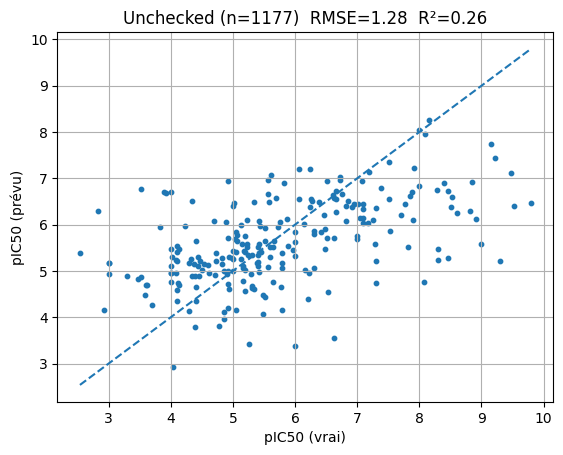

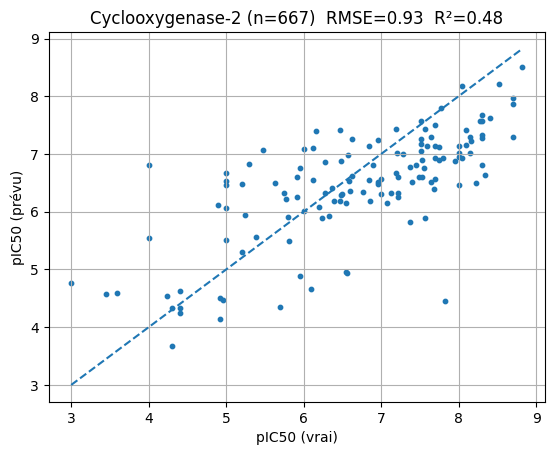

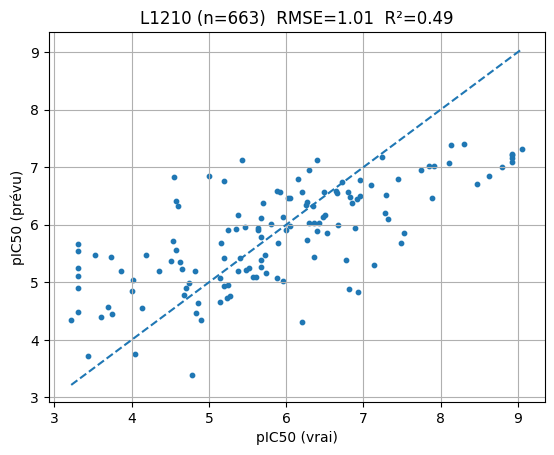

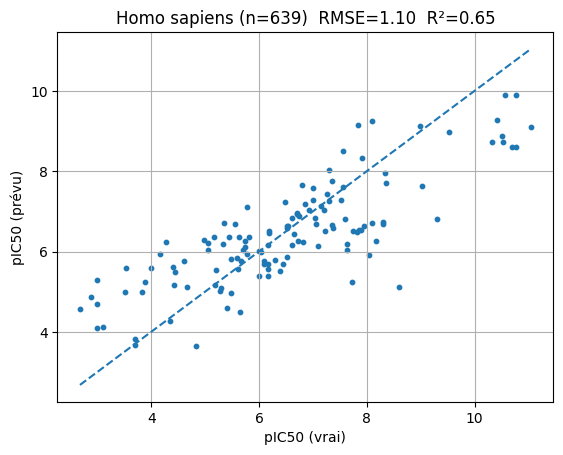

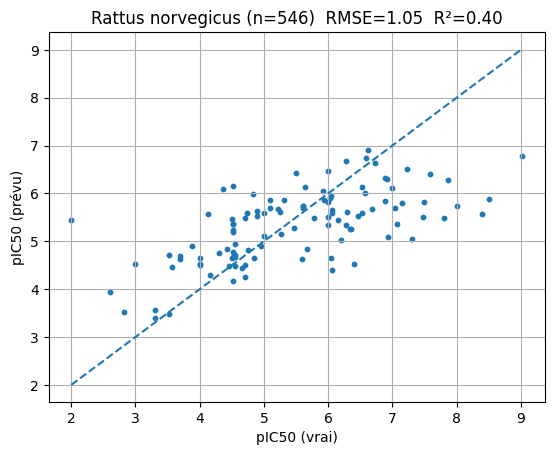

In [36]:
def plot_target_scatter(tgt, idxs, X, y):
    X_tr, X_te, y_tr, y_te = train_test_split(X[idxs], y[idxs], test_size=0.2, random_state=0)
    mdl = KernelRidge(alpha=1.0, kernel="linear").fit(X_tr, y_tr)
    y_pred = mdl.predict(X_te)
    rmse = (mean_squared_error(y_te, y_pred))**0.5
    r2v  = r2_score(y_te, y_pred)

    plt.figure()
    plt.scatter(y_te, y_pred, s=10)
    lo, hi = float(min(y_te.min(), y_pred.min())), float(max(y_te.max(), y_pred.max()))
    plt.plot([lo, hi],[lo, hi], linestyle="--")
    plt.xlabel("pIC50 (vrai)"); plt.ylabel("pIC50 (prévu)")
    plt.title(f"{tgt} (n={len(idxs)})  RMSE={rmse:.2f}  R²={r2v:.2f}")
    plt.grid(True)
    plt.show()

if PLOT_SAMPLE > 0:
    top_targets = rep["target"].head(PLOT_SAMPLE).tolist()
    for tgt in top_targets:
        plot_target_scatter(tgt, target_to_idxs[tgt], X, y)


In [21]:
def predict_for_smiles(smiles, trained, widen_on_ood=True):
    x = featurize_smiles_list([smiles])[0]
    rows = []
    for t in trained:
        mdl = t["model"]; Xtr = t["X_train"]; tgt = t["target"]; q90 = t["q90"]
        y_hat = float(mdl.predict(x.reshape(1,-1))[0])
        sim = tanimoto_max_to_train(x, Xtr) if USE_RDKIT else cosine_max_to_train(x, Xtr)
        ood = 1.0 - sim
        half = q90 * (1.3 if (widen_on_ood and ood > 0.5) else 1.0)
        rows.append({
            "target": tgt,
            "pIC50_pred": y_hat,
            "ci90_lo": y_hat - half,
            "ci90_hi": y_hat + half,
            "ood": ood
        })
    return pd.DataFrame(rows).sort_values("pIC50_pred", ascending=False).reset_index(drop=True)

ranked = predict_for_smiles(DEMO_SMILES, trained, widen_on_ood=True)
ranked.head(20)


,target,pIC50_pred,ci90_lo,ci90_hi,ood
0,Angiotensin II type 2 (AT-2) receptor,6.865101,5.518313,8.211889,0.261981
1,Neprilysin,6.826371,5.257119,8.395624,0.125442
2,Human immunodeficiency virus type 1 protease,6.441303,4.873631,8.008976,0.201009
3,Angiotensin II receptor (AT-1) type-1,6.263722,4.543265,7.984179,0.277481
4,Angiotensin II type 1a (AT-1a) receptor,6.247551,5.056050,7.439052,0.274844
5,Delta opioid receptor,6.237042,4.113919,8.360165,0.242087
6,Endothelin receptor ET-A,6.161557,4.166383,8.156732,0.210082
7,Dihydrofolate reductase,6.153995,4.187352,8.120639,0.308281
8,Human immunodeficiency virus type 1 reverse tr...,6.034778,4.273873,7.795683,0.288932
9,Serotonin transporter,5.960714,4.667086,7.254342,0.188839


,target,pIC50_pred,ci90_lo,ci90_hi,half_width,ood
0,Cyclooxygenase-2,5.292801,3.747343,6.838260,1.545458,0.243082
1,Homo sapiens,4.645960,2.921575,6.370345,1.724385,0.285619
2,Unchecked,4.564080,2.275885,6.852275,2.288195,0.265261
3,Rattus norvegicus,4.460980,2.840052,6.081908,1.620928,0.265456
4,L1210,3.851869,2.309037,5.394700,1.542831,0.265456


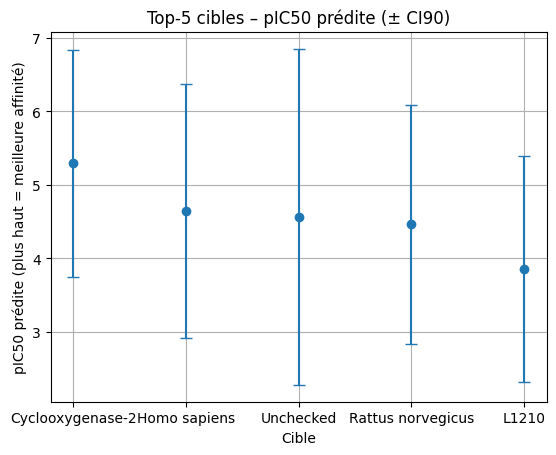

In [38]:
# === Test rapide d'un SMILES ===
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 1) Fonction de prédiction (si pas déjà définie)
def predict_for_smiles(smiles, trained, widen_on_ood=True):
    x = featurize_smiles_list([smiles])[0]
    rows = []
    for t in trained:
        mdl = t["model"]; Xtr = t["X_train"]; tgt = t["target"]; q90 = t["q90"]
        y_hat = float(mdl.predict(x.reshape(1,-1))[0])
        sim = tanimoto_max_to_train(x, Xtr) if USE_RDKIT else cosine_max_to_train(x, Xtr)
        ood = 1.0 - sim
        half = q90 * (1.3 if (widen_on_ood and ood > 0.5) else 1.0)
        rows.append({
            "target": tgt,
            "pIC50_pred": y_hat,
            "ci90_lo": y_hat - half,
            "ci90_hi": y_hat + half,
            "half_width": half,
            "ood": ood,
        })
    return pd.DataFrame(rows).sort_values("pIC50_pred", ascending=False).reset_index(drop=True)

# 2) Choisis une molécule (ex: ibuprofène)
DEMO_SMILES = "NS(=O)(=O)c1ccc(cc1)C(F)(F)F"

# 3) Prédire et afficher le top
ranked = predict_for_smiles(DEMO_SMILES, trained, widen_on_ood=True)
display(ranked.head(10))

# 4) Petit graphe: top-5 pIC50 avec barres d’erreur (CI90)
top5 = ranked.head(5).copy()
plt.figure()
plt.errorbar(
    top5["target"], top5["pIC50_pred"],
    yerr=top5["half_width"],
    fmt='o', capsize=4
)
plt.title("Top-5 cibles – pIC50 prédite (± CI90)")
plt.ylabel("pIC50 prédite (plus haut = meilleure affinité)")
plt.xlabel("Cible")
plt.grid(True)
plt.show()
